# QBUS2820 Assignment 2

**SID:** 510575452

In [105]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from forecast import histogram, qq_plot, intervalforecast,fanchart
from sklearn.metrics import mean_squared_error

# Executive Summary

The project requirements aims to develop a time series model to forecast the Consumer Price Index (CPI) using data given to us that consists of 100 entries ranging from quarterly periods from March 1997 to December 2021.  The main objective is to predict the CPI values for March 2022 to December 2023 using multiple-step-ahead approaches.  Having accurate CPI forecasts is essential for economic and financial decision making.  

Our analysis begins with Exploratory Data Analysis (EDA), observing initial data, seasonal patterns, and autocorrelation structures within the dataset. Key EDA elements include trend analysis, seasonal plots to assess yearly patterns, and ACF/PCF plots for data dependency.

For model development, we explored several techniques, including time series decomposition and stationarity testing (ADF), before focusing on a selection of models: SARIMA and various exponential smoothing methods (Simple Exponential Smoothing, Holt, and Holt-Winters variations). Model validation is conducted using an expanding window split approach to identify the most accurate forecast method based on the lowest Mean Squared Error (MSE) and AIC criteria.

Our results indicate that the SARIMA model, based on AIC selection, is the best performing model for this forecast. The final SARIMA model will be utilized to provide reliable CPI projections for decision-making applications.

# Loading in Dataset

## Raw Data

In [106]:
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

CPI_train_data

,CPI
Quarter,
Mar-97,94.5
Jun-97,93.1
Sep-97,95.4
Dec-97,96.3
Mar-98,96.0
...,...
Dec-20,125.3
Mar-21,123.6
Jun-21,124.5


**Note:**

- There are 100 entries


- Shows each quarter from 1997 - 2021


- Date layout: <abbreviation_of_month>-yy

# Data Cleaning

## Parsed Data

In [107]:
CPI_train_data.index = pd.to_datetime(
    CPI_train_data.index, format='%b-%y', errors='coerce')

CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


Data is parsed so that the index of `CPI_Train_data` is converted into a quarterly period index format instead of `<abbreviation_of_month>-yy` format.  This will make the analysis consistent with the data provided and easier to apply to time series related libraries.

## Looking at Key Characteristics of the dataset

In [108]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


Checking that it starts from the first quarter in 1997 as specified in the assignment specifications of the dataset.

In [109]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


Checking that it ends at the last quarter in 2021 as specified in the assignment specifications of the dataset.

In [110]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

Only variable that we are dealing with is `CPI` which will be used to forecast the next 8 periods of the CPI data set.

In [111]:
CPI_train_data.shape

(100, 1)

There are 100 rows by 1 column.

### Removing null values

In [112]:
clean_CPI_train_data = CPI_train_data.dropna()

**Note:** even though there are no null values, it is great practice to always include this step in the data cleaning phase.

## Looking at the information of the dataset

In [113]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [114]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [115]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

This is to verify that there are no null values in the CPI dataset.

# EDA

## Looking at the trend of the data

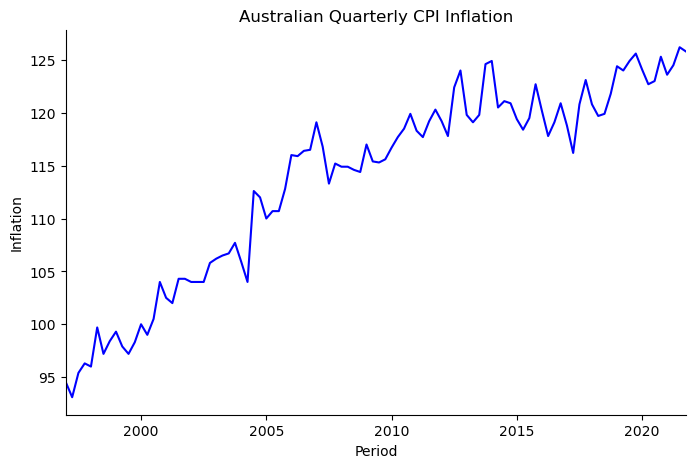

In [116]:
y = clean_CPI_train_data['CPI']

fig_CPI_initial, ax_CPI_intial = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_CPI_intial)
ax_CPI_intial.set_xlabel('Period')
ax_CPI_intial.set_ylabel('Inflation')
ax_CPI_intial.set_title('Australian Quarterly CPI Inflation')
ax_CPI_intial.set_xticks([], minor=True)
sns.despine()
plt.show()

Based off the line graph for the Australian Quarterly CPI inflation, it shows a positive trend which indicates rise of prices overtime.  It also shows volatility of prices over the years but in particular in 2008, it shows the deflation of prices due to reduction in price of automative fuels (Treasury Ministers, 2021).

## Seasonal Plots

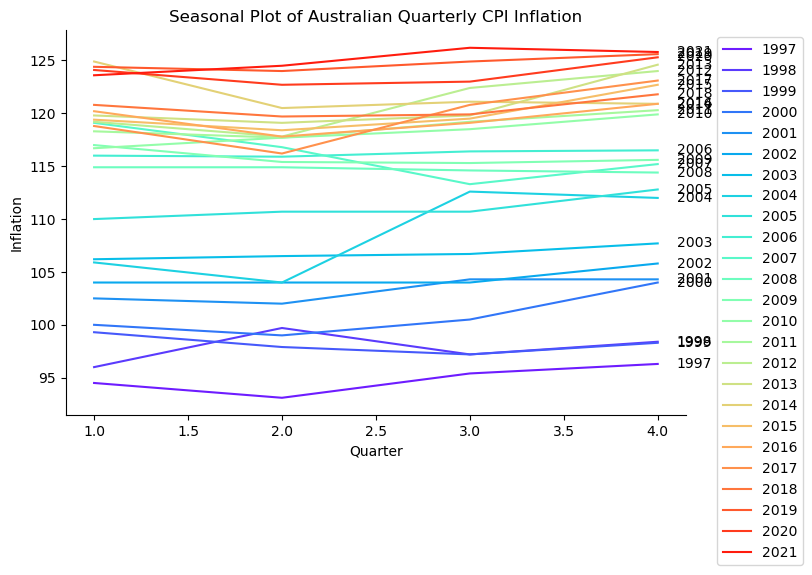

In [117]:
# Customize the colors for each year (example with a range of colors)
custom_palette = sns.color_palette("rainbow", len(
    clean_CPI_train_data.index.year.unique()))

fig_CPI_seasonal, ax_CPI_seasonal = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.quarter,
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonal
)

ax_CPI_seasonal.set_xlabel('Quarter')
ax_CPI_seasonal.set_ylabel('Inflation')
ax_CPI_seasonal.set_title('Seasonal Plot of Australian Quarterly CPI Inflation')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonal.text(
        # Position slightly to the right of the last point
        x=year_data.index.quarter.max() + 0.1,
        y=year_data['CPI'].iloc[-1],            # Last CPI value for the year
        s=str(year),                            # Year label
        verticalalignment='center'
    )

# Customize legend position
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

As seen from the seasonal plot, we can identify that the CPI at the end of each year increases overtime from 1997-2021, however it shows in the middle period that 2006 ends higher than years 2007-2009.  Furthermore, we can see that there are major increases at the of the three group years (1997-1998), (2000-2003), (2004-2009), and (2010-2021).  Lastly, the main spikes occur during **Quarter 2** and **Quarter 3** for some of the years.

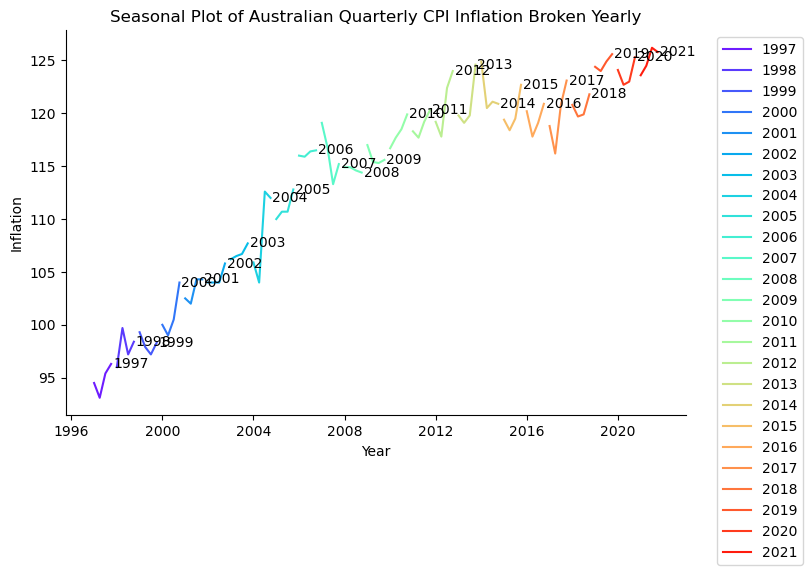

In [118]:
fig_CPI_seasonality_month_broken_yearly, ax_CPI_seasonality_broken_yearly = plt.subplots(figsize=(8, 5))

# Plot the line plot with customized colors
sns.lineplot(
    x=clean_CPI_train_data.index.to_timestamp(),
    y=clean_CPI_train_data['CPI'],
    hue=clean_CPI_train_data.index.year,
    palette=custom_palette,
    ax=ax_CPI_seasonality_broken_yearly
)

ax_CPI_seasonality_broken_yearly.set_xlabel('Year')
ax_CPI_seasonality_broken_yearly.set_ylabel('Inflation')
ax_CPI_seasonality_broken_yearly.set_title(
    'Seasonal Plot of Australian Quarterly CPI Inflation Broken Yearly')

# Adding year labels at the end of each line
for year in clean_CPI_train_data.index.year.unique():
    year_data = clean_CPI_train_data[clean_CPI_train_data.index.year == year]
    ax_CPI_seasonality_broken_yearly.text(
        # Position slightly to the right of the last point
        x=year_data.index.to_timestamp().max() + pd.DateOffset(months=1),
        y=year_data['CPI'].iloc[-1],           
        s=str(year),                            
        verticalalignment='center'
    )

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
sns.despine()
plt.show()

This graph breaks down the yearly trends in CPI data based on the seasonal patterns illustrated above. It distinctly highlights the individual inflation trend for each year from 1997 to 2021, providing a clear view of how CPI inflation has evolved across the entire period.


## ACF and PACF Plots

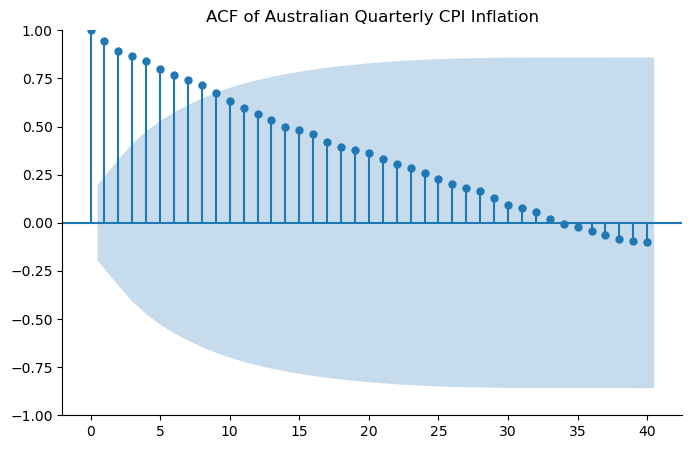

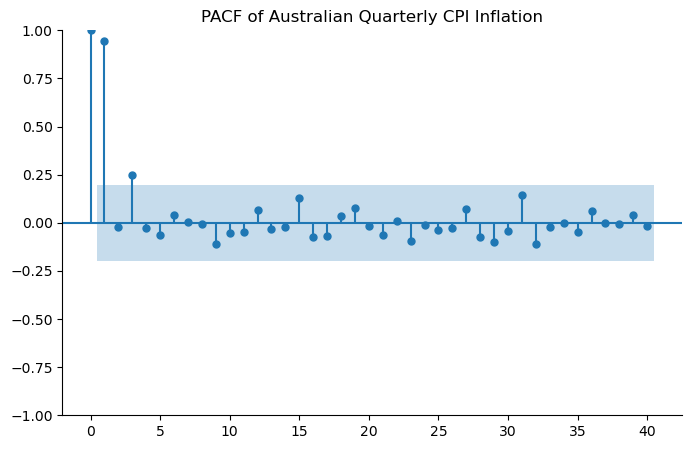

In [119]:
# ACF plots of the CPI data for 40 lags
fig_CPI_acf, ax_CPI_acf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(y, lags=40, ax=ax_CPI_acf, alpha=0.05)
ax_CPI_acf.set_title('ACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

# PACF plots of the CPI data for 40 lags
fig_CPI_pacf, ax_CPI_pacf = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax_CPI_pacf, alpha=0.05)
ax_CPI_pacf.set_title('PACF of Australian Quarterly CPI Inflation')
sns.despine()
plt.show()

The ACF and PACF plots for Australian quarterly CPI inflation indicate a strong autoregressive structure, with significant autocorrelation at lower lags that gradually declines, pointing to a non-stationary time series. The ACF's slow decay suggests a potential trend in the data, while the PACF's rapid drop after lag 1 implies an autoregressive process of low order, likely AR(1). These findings suggest that the CPI inflation series may benefit from differencing and an ARIMA(1,1,0) model for further analysis. Seasonal effects could also be explored due to the economic nature of the data and potentially use SARIMA model to further analyse this.  

# Model Development

## Time Series Decomposition

In order to pick which models are suitable for the CPI dataset, applying time series decomposition is essential in the model development stage since it enhances the understanding of data patterns by breaking the series into trend, seasonality, and residual components.  This makes it easier to identify patterns and in turn make improvements to forecasting accuracy.  Furthermore, it helps achieve stationarity, which is crucial for models such as SARIMA. and enhances interpretability by isolating each components effect.  This logical approach helps create a more accurate, insightful forecasting models.

In [120]:
window_size = 12    
decomposition = seasonal_decompose(y, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

In [121]:
decomposition.seasonal.tail()

Quarter
2020Q4    0.894602
2021Q1    0.243466
2021Q2   -0.937595
2021Q3   -0.200473
2021Q4    0.894602
Freq: Q-DEC, Name: seasonal, dtype: float64

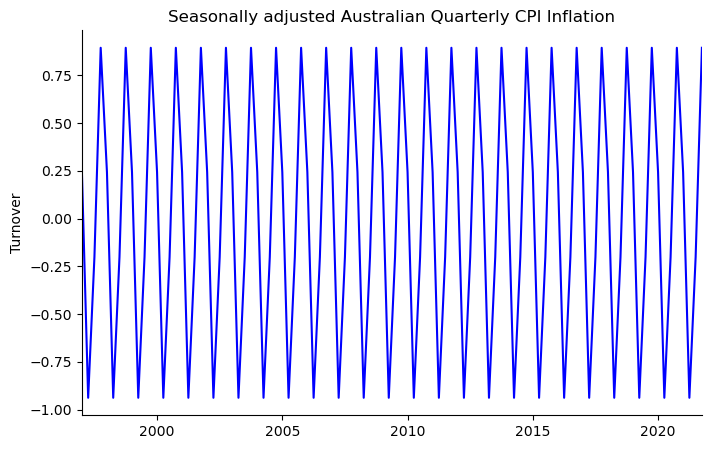

In [122]:
fig_seasonal_decomposition, ax_seasonal_decomposition = plt.subplots(
    figsize=(8, 5))
decomposition.seasonal.plot(color='blue', ax=ax_seasonal_decomposition)
ax_seasonal_decomposition.set_xlabel('')
ax_seasonal_decomposition.set_ylabel('Turnover')
ax_seasonal_decomposition.set_title(
    'Seasonally adjusted Australian Quarterly CPI Inflation')
ax_seasonal_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

The seasonality plot for Australian quarterly CPI inflation reveals a strong, stable cyclical pattern with consistent amplitude and a four-quarter periodicity, indicating a reliable annual seasonality in inflation. This stable pattern suggests that recurring factors influence inflation similarly each year, unaffected by major external shocks. Such predictable seasonality is advantageous for forecasting, as seasonal models (e.g., SARIMA) can leverage this regularity for improved accuracy. The periodic nature may also reflect underlying economic cycles tied to consumer or production behaviors, making this insight valuable for both forecasting and understanding inflation drivers.

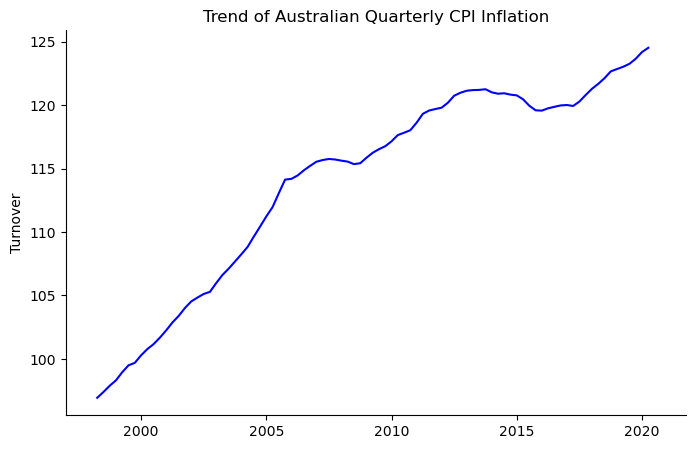

In [123]:
fig_trend_decomposition, ax_trend_decomposition = plt.subplots(figsize=(8, 5))
decomposition.trend.plot(color="blue", ax=ax_trend_decomposition)
ax_trend_decomposition.set_xlabel('')
ax_trend_decomposition.set_ylabel('Turnover')
ax_trend_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_trend_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

The trend plot of Australian quarterly CPI inflation from the time series decomposition shows a steady upward trajectory, indicating a long-term increase in consumer prices. This reflects sustained inflation, with periodic accelerations and occasional slowdowns. For instance, there is rapid growth between 2000 and 2008, likely reflecting a period of economic expansion, followed by a plateau around 2015, which might align with low-inflation policies or economic stabilization. The recent rise post-2015 suggests a renewed inflationary trend, potentially due to economic factors like policy shifts or global influences on the economy. This trend highlights the persistent rise in the cost of living over time, underscoring the need for policymakers to monitor and manage inflation to sustain economic stability.  

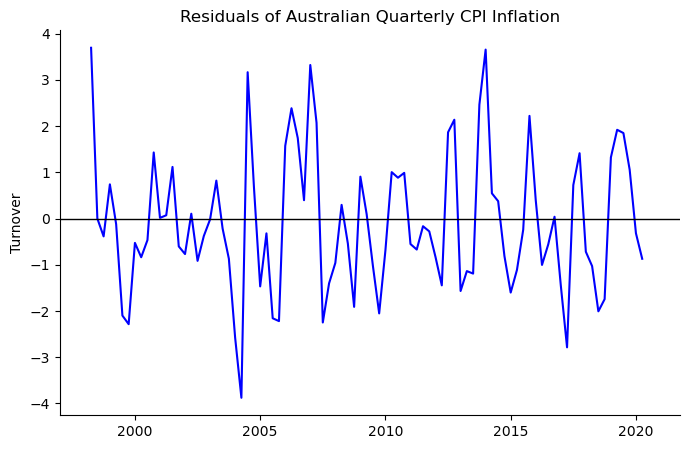

In [155]:
fig_resid_decomposition, ax_resid_decomposition = plt.subplots(figsize=(8, 5))
decomposition.resid.plot(color='blue', ax=ax_resid_decomposition)
ax_resid_decomposition.axhline(0, color='black', lw=1)
ax_resid_decomposition.set_xlabel('')
ax_resid_decomposition.set_ylabel('Turnover')
ax_resid_decomposition.set_title('Residuals of Australian Quarterly CPI Inflation')
ax_resid_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

The residual plot for Australian quarterly CPI inflation shows random fluctuations around zero, indicating that the time series decomposition effectively removed trend and seasonal components, leaving only noise. Occasional large deviations, such as in the early 2000s and around 2008, likely reflect economic shocks or policy impacts not captured by trend or seasonality. The absence of a systematic pattern in the residuals suggests a good model fit, implying that future forecasts based on the trend and seasonal components should be reliable, as no further predictable information remains in the residuals.

By analysing the trend, seasonality, and residuals during the time series decomposition phase, we can identify potential models for achieving the most accurate CPI forecast. We will implement smoothing models such as simple exponential, Holt exponential, and Holt-Winters exponential in various forms, along with SARIMA models. Given the clear presence of seasonality, first-order differencing will be applied to enable SARIMA modeling.

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

**Formula:** 

\begin{align*}
\boldsymbol{\Delta} y_t = \boldsymbol{\alpha} + \boldsymbol{\beta} t + \boldsymbol{\gamma} y_{t-1} + \boldsymbol{\delta}_1 \boldsymbol{\Delta} y_{t-1} \dots + \boldsymbol{\delta}_{p-1} \boldsymbol{\Delta} y_{t-p+1} + \boldsymbol{\epsilon}_t,
\end{align*}


where $\boldsymbol{\alpha}$ is a constant term,  $\boldsymbol{\beta} t$ is the trend coefficient, $\boldsymbol{\gamma} y_{t-1}$ is the coefficient of the lagged level of time series, $\boldsymbol{\delta}_i$ are the coefficients of the lagged differences, $t$ is the time index, $p$ is the number of lags, and $\boldsymbol{\epsilon}_t$ is the error term  

$\boldsymbol{H_0}:$ The time series is non-stationary.


$\boldsymbol{H_A}:$ The time series is stationary.


**Threshold:**


$\boldsymbol{\alpha} = 0.05$

In [161]:
def test_stationarity(timeseries):

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    if dftest[0] < dftest[4]["5%"]:
        print('Reject H0 - Time Series is stationary')
    else:
        print('Failed to reject H0 - Time series is non-stationary')


test_stationarity(y)

Results of Dickey-Fuller Test:
Test Statistic                 -2.133199
p-value                         0.231376
#Lags Used                      6.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64
Failed to reject H0 - Time series is non-stationary


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  This further supports the use of smoothing models and SARIMA models to forecast the future predictions of the Australian CPI Inflation.

## SARIMA Model

The SARIMA model is ideal for forecasting CPI data because it captures seasonal patterns, trends, and short-term dependencies commonly found in economic series. Unlike standard ARIMA, which addresses only trends and short-term dependencies, SARIMA includes seasonal components that enable it to effectively handle regular seasonal fluctuations. By incorporating both regular and seasonal differencing, SARIMA ensures stationarity, which is a key factor for reliable predictions. Its flexibility in managing autoregressive and moving average components for seasonal cycles allows it to account for recurring patterns and underlying inflation dynamics, making it especially valuable for accurate, long-term CPI forecasts essential for economic planning and decision-making.

In [126]:
sarima_model_aic = pm.auto_arima(y, seasonal=True, m=4,
                             information_criterion='aic', test='adf',
                             suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=396.102, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=422.341, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=420.980, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=414.261, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=422.781, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : AIC=394.706, Time=0.09 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : AIC=396.295, Time=0.06 sec
 ARIMA(2,1,2)(0,0,2)[4] intercept   : AIC=396.048, Time=0.29 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : AIC=394.186, Time=0.07 sec
 ARIMA(2,1,2)(2,0,0)[4] intercept   : AIC=395.309, Time=0.55 sec
 ARIMA(2,1,2)(2,0,1)[4] intercept   : AIC=397.790, Time=1.07 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : AIC=394.774, Time=0.15 sec
 ARIMA(2,1,1)(1,0,0)[4] intercept   : AIC=394.663, Time=0.11 sec
 ARIMA(3,1,2)(1,0,0)[4] intercept   : AIC=398.695, Time=0.11 sec
 ARIMA(2,1,3)(1,0,0)[4] intercept   : AIC=398.6

Using the `auto_arima` function is a way to automate the process of selecting an optimal model configuration without manually testing different combinations.

`auto_arima` is configured with `seasonal=True` with period of `m=4` which is useful for CPI dataset since it is represented in quarters.  The `information_criterion='aic'` is used to evaluate models based on the AIC, aiming to minimise this value for the best model fit.  Furthermore, `test='adf'` is used for the function to perform the Augmented Dickey-Fuller (ADF) test to determine the differencing order needed to make the series stationary.

For presentation purposes, `suppress_warnings=True` is used to keep the output cleaner by hiding warning messages, while `trace=True` provides detailed output, showing each model tried along with its AIC score and the time taken to fit.

From the above, the function uses a stepwise search across different combinations of the SARIMA parameters: $(p, d, q)$ for non ARIMA component and $(P, D, Q, m)$ for the seasonal component.  Each line of the output shows the different configurations with its corresponding AIC score.  By comparing each one, the function identified that the best SARIMA model is ARIMA(2, 1, 2)(1, 0, 0)[4] with intercept, which has an AIC score of 394.186.

In [127]:
sarima_model_aic.set_params()

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 0, 4),
      suppress_warnings=True)

In [128]:
sarima_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Sat, 02 Nov 2024   AIC                            394.186
Time:                                    19:47:25   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The SARIMAX(2, 1, 2)×(1, 0, [], 4) model fits the quarterly data well, with an AIC of 394.186 and BIC of 412.351, indicating a good balance between fit quality and complexity. Significant coefficients for the intercept, AR(2), and seasonal AR terms highlight their relevance in capturing data patterns, while insignificant AR(1) and MA terms suggest limited impact.

In [129]:
sarima_model_bic = pm.auto_arima(y, seasonal=True, m=4,
                                 information_criterion='bic', test='adf',
                                 suppress_warnings=True, trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : BIC=416.863, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : BIC=427.532, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : BIC=431.360, Time=0.02 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : BIC=424.642, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[4]             : BIC=425.376, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[4] intercept   : BIC=412.871, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[4] intercept   : BIC=411.865, Time=0.05 sec
 ARIMA(2,1,2)(1,0,0)[4] intercept   : BIC=412.351, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : BIC=408.676, Time=0.05 sec
 ARIMA(1,1,2)(1,0,0)[4] intercept   : BIC=410.345, Time=0.04 sec
 ARIMA(1,1,2)(0,0,1)[4] intercept   : BIC=411.292, Time=0.08 sec
 ARIMA(1,1,2)(1,0,1)[4] intercept   : BIC=411.266, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[4] intercept   : BIC=407.290, Time=0.04 sec
 ARIMA(0,1,2)(1,0,0)[4] intercept   : BIC=410.796, Time=0.06 sec
 ARIMA(0,1,2)(0,0,1)[4] intercept   : BIC=411.1

Majoriy of the configuration are mentioned in the development of the SARIMA model using AIC but in this case, we make the following changes to account for BIC instead: `information_criterion='bic'`.

From the above, the function identified that the best SARIMA model is ARIMA(0, 1, 3)(0, 0, 0)[4] with intercept, which has a BIC score of 406.951.


In [130]:
sarima_model_bic.set_params()

ARIMA(order=(0, 1, 3), scoring_args={}, seasonal_order=(0, 0, 0, 4),
      suppress_warnings=True)

In [131]:
sarima_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -191.988
Date:                Sat, 02 Nov 2024   AIC                            393.976
Time:                        19:47:27   BIC                            406.951
Sample:                    03-31-1997   HQIC                           399.226
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3181      0.098      3.248      0.001       0.126       0.510
ma.L1         -0.2113      0.110     -1.921      0.055      -0.427       0.004
ma.L2         -0.5300      0.080     -6.594      0.000      -0.688      -0.372
ma.L3          0.2455      0.109      2.255      0.024       0.032       0.459
sigma2         2.8079      0.418      6.722      0.000       1.989       3.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


The SARIMAX(0, 1, 3) model fits the quarterly data well, with an AIC of 393.976 and a BIC of 406.951, which suggests an optimal balance between model fit and complexity.  Significant coefficients for the intercept, MA(2) and MA(3) terms highlight their importance in capturing data patterns, while the insignificant MA(1) term suggests a limited impact.

In [132]:
sarima_aic_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)
sarima_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -190.093
Date:                            Sat, 02 Nov 2024   AIC                            394.186
Time:                                    19:47:27   BIC                            412.351
Sample:                                03-31-1997   HQIC                           401.536
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7280      0.242      3.002      0.003       0.253       1.203
ar.L1          0.0326      0.105      0.309      0.757      -0.174       0.239
ar.L2         -0.7778      0.103     -7.572      0.000      -0.979      -0.576
ma.L1         -0.2222      0.165     -1.348      0.178      -0.545       0.101
ma.L2          0.2659      0.180      1.477      0.140      -0.087       0.619
ar.S.L4       -0.3322      0.113     -2.951      0.003      -0.553      -0.112
sigma2         2.6974      0.379      7.126      0.000       1.956       3.439
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.35
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.99
Prob(H) (two-sided):                  0.49   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
sarima_bic_model = pm.ARIMA(order=(0, 1, 3), seasonal_order=(0, 0, 0, 4), solver='lbfgs', maxiter=200,
                        suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)
sarima_bic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -191.988
Date:                Sat, 02 Nov 2024   AIC                            393.976
Time:                        19:47:27   BIC                            406.951
Sample:                    03-31-1997   HQIC                           399.226
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3181      0.098      3.248      0.001       0.126       0.510
ma.L1         -0.2113      0.110     -1.921      0.055      -0.427       0.004
ma.L2         -0.5300      0.080     -6.594      0.000      -0.688      -0.372
ma.L3          0.2455      0.109      2.255      0.024       0.032       0.459
sigma2         2.8078      0.418      6.722      0.000       1.989       3.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                13.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

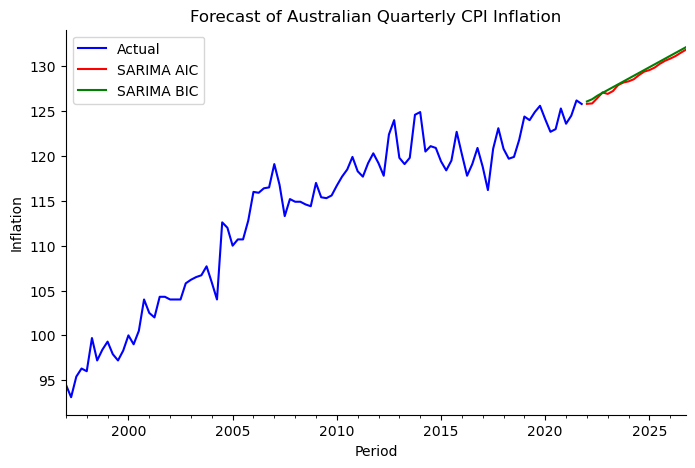

In [134]:
# Plot the forecast of the SARIMA model
fig_sarima_forecast, ax_sarima_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_sarima_forecast)
sarima_aic_model.predict(20).plot(color='r', ax=ax_sarima_forecast)
sarima_bic_model.predict(20).plot(color='g', ax=ax_sarima_forecast)
ax_sarima_forecast.set_xlabel('Period')
ax_sarima_forecast.set_ylabel('Inflation')
ax_sarima_forecast.set_title('Forecast of Australian Quarterly CPI Inflation')
sns.despine()
plt.legend(loc='best', labels=['Actual', 'SARIMA AIC', 'SARIMA BIC'])
plt.show()

## Smoothing Models

Smoothing models like Simple Exponential Smoothing, Holt Exponential Smoothing, and Holt-Winters Exponential Smoothing are ideal for CPI data as they capture inflation patterns through varying levels of trend and seasonality. Simple Exponential Smoothing suits stable CPI data, while Holt’s method accounts for trends, and Holt-Winters handles both trends and seasonality which is important for seasonal CPI fluctuations. These models are responsive to recent data, adapting quickly to economic shifts, and are easier to interpret than complex models, making them well-suited for presenting CPI forecasts to stakeholders who need clear insights into inflation trends.

### Simple Exponential Smoothing 

In [135]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(optimized=True)
fitted_simple_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


### Holt Exponential Smoothing

In [136]:
holt_exponential_smoothing = Holt(y, initialization_method="estimated")
fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(optimized=True)
fitted_holt_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,Holt,SSE,357.486
Optimized:,True,AIC,135.393
Trend:,Additive,BIC,145.813
Seasonal:,None,AICC,136.296
Seasonal Periods:,None,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4700246,alpha,True
smoothing_trend,0.000000,beta,True


#### Plotting Smoothing Model Forecasts

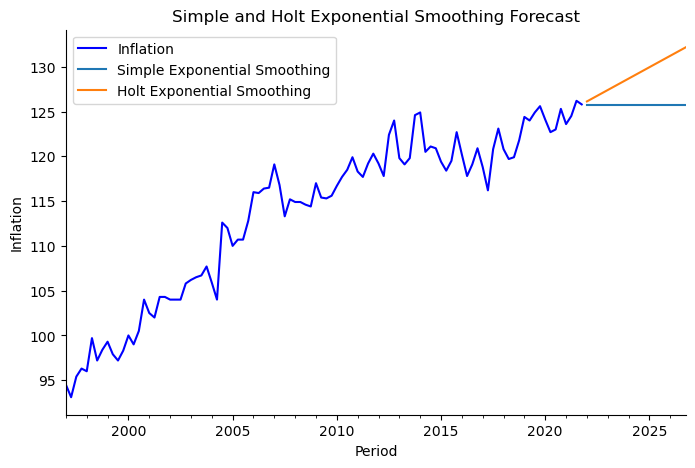

In [137]:
horizon = 20

smoothing_models = [fitted_simple_exponential_smoothing,
                    fitted_holt_exponential_smoothing]
model_names = ['Simple Exponential Smoothing',
               'Holt Exponential Smoothing']

fig_forecast, ax_forecast = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')

for model, name in zip(smoothing_models, model_names):
    pred = model.forecast(horizon)
    pred.plot(ax=ax_forecast, label=name)

ax_forecast.set_xlabel('Period')
ax_forecast.set_ylabel('Inflation')
ax_forecast.set_title('Simple and Holt Exponential Smoothing Forecast')
plt.legend(loc='best')
sns.despine()
plt.show()

### Holt-Winters Exponential Smoothing

In [138]:
ahw=ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,291.201
Optimized:,True,AIC,122.884
Trend:,Additive,BIC,143.726
Seasonal:,Additive,AICC,125.356
Seasonal Periods:,4,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5691148,alpha,True
smoothing_trend,4.7635e-10,beta,True


In [139]:
mhw = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                           seasonal="mul", initialization_method="estimated").fit()
mhw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,276.717
Optimized:,True,AIC,133.782
Trend:,Additive,BIC,175.465
Seasonal:,Multiplicative,AICC,142.227
Seasonal Periods:,12,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5404220,alpha,True
smoothing_trend,0.000000,beta,True


In [140]:
mhw_damped = ExponentialSmoothing(y, seasonal_periods=12, trend="add",
                                  seasonal="mul", damped_trend=True, initialization_method="estimated").fit()
mhw_damped.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,269.035
Optimized:,True,AIC,132.967
Trend:,Additive,BIC,177.255
Seasonal:,Multiplicative,AICC,142.467
Seasonal Periods:,12,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4759881,alpha,True
smoothing_trend,2.1008e-12,beta,True


In [141]:
ahw_log = ExponentialSmoothing(np.log(y), seasonal_periods=12, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw_log.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,0.022
Optimized:,True,AIC,-810.909
Trend:,Additive,BIC,-769.226
Seasonal:,Additive,AICC,-802.464
Seasonal Periods:,12,Date:,"Sat, 02 Nov 2024"
Box-Cox:,False,Time:,19:47:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5218593,alpha,True
smoothing_trend,0.0240859,beta,True


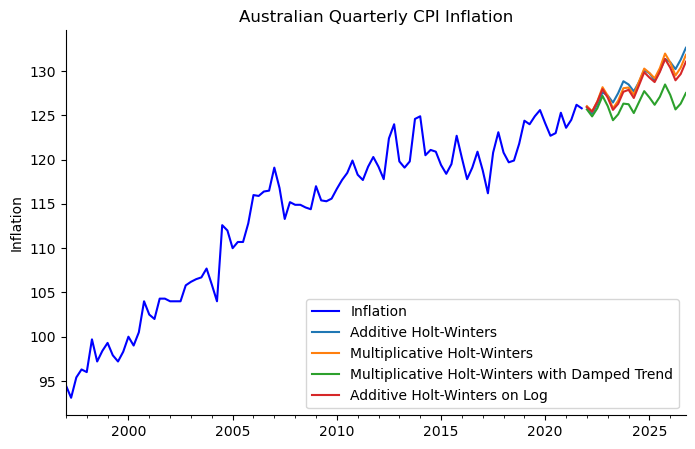

In [142]:
horizon = 20
holt_winters_models = [ahw, mhw, mhw_damped, ahw_log]
model_names = [
    'Additive Holt-Winters',
    'Multiplicative Holt-Winters',
    'Multiplicative Holt-Winters with Damped Trend',
    'Additive Holt-Winters on Log'
]

fig_comparison_hw, ax_comparison_hw = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
for i, model in enumerate(holt_winters_models):
    pred = model.forecast(horizon)

    if model_names[i] == 'Additive Holt-Winters on Log':
        pred = np.exp(pred)

    pred.plot(label=model_names[i])

ax_comparison_hw.set_xlabel('')
ax_comparison_hw.set_ylabel('Inflation')
ax_comparison_hw.set_title('Australian Quarterly CPI Inflation')
plt.legend(loc='best')
sns.despine()
plt.show()

# Model Validation

## Expanding Window Split

In [143]:
ts = np.log(y)  

validation = y['2017Q1':].index
start = y.index.get_loc('2017Q1')

seasonal_walk_pred = []
simple_exponential_smoothing_pred = []
holt_exponential_smoothing_pred = []
ahw_pred = []
mhw_pred = []
mhw_damped_pred = []
ahw_log_pred = []
sarima_aic_pred = []
sarima_bic_pred = []

for i in range(start, len(y)):

    seasonal_walk_pred.append(y.iloc[i-1])  # seasonal random walk forecast

    simple_exponential_smoothing_model = SimpleExpSmoothing(y.iloc[:i], initialization_method="estimated").fit()

    simple_exponential_smoothing_pred.append(simple_exponential_smoothing_model.forecast(1)[-1])  # simple exponential smoothing forecast

    holt_exponential_smoothing_model = Holt(y.iloc[:i], initialization_method="estimated").fit()

    holt_exponential_smoothing_pred.append(holt_exponential_smoothing_model.forecast(1)[-1])  # holt exponential smoothing forecast

    ahw_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="add", initialization_method="estimated").fit()
    
    ahw_pred.append(ahw_model.forecast(1)[-1])  # additive holt winters forecast

    mhw_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="mul", initialization_method="estimated").fit()
    
    mhw_pred.append(mhw_model.forecast(1)[-1])  # multiplicative holt winters forecast

    mhw_damped_model = ExponentialSmoothing(y.iloc[:i], seasonal_periods=4, trend="add",
                                            seasonal="mul", damped_trend=True, initialization_method="estimated").fit()
    
    mhw_damped_pred.append(mhw_damped_model.forecast(1)[-1])  # multiplicative holt winters forecast

    ahw_log_model = ExponentialSmoothing(ts.iloc[:i], seasonal_periods=4, trend="add",
                                        seasonal="add", initialization_method="estimated").fit()
    
    resid = (ts.iloc[:i]-ahw_log_model.fittedvalues)[12:]  # residuals
    # forecast with a retransformation adjustment
    y_pred = np.exp(ahw_log_model.forecast(1)[-1])*np.mean(np.exp(resid))
    ahw_log_pred.append(y_pred)  # log additive holt winters forecast

    sarima_aic_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y.iloc[:i])
    
    sarima_aic_pred.append(sarima_aic_model.predict(n_periods=1)[-1])  

    sarima_bic_model = pm.ARIMA(order=(0, 1, 3), seasonal_order=(0, 0, 0, 4), solver='lbfgs', maxiter=200,
                            suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y.iloc[:i])
    
    sarima_bic_pred.append(sarima_bic_model.predict(n_periods=1)[-1]) 

columns = ['Seasonal RW', 'Simple Exponential Smoothing', 'Holt Exponential Smoothing',
              'Additive Holt-Winters', 'Multiplicative Holt-Winters', 'Multiplicative Holt-Winters with Damped Trend',
                'Additive Holt-Winters on Log', 'SARIMA (AIC)', 'SARIMA (BIC)']
results = np.vstack([seasonal_walk_pred, simple_exponential_smoothing_pred, holt_exponential_smoothing_pred,
                     ahw_pred, mhw_pred, mhw_damped_pred, ahw_log_pred, sarima_aic_pred, sarima_bic_pred]).T

results = pd.DataFrame(results, columns=columns, index=validation)

For forecasting a CPI dataset, which often exhibits gradual trends and seasonal variations over time, the expanding window split is particularly effective. By progressively adding more quarters of historical CPI data to the training set, this method allows the model to capture both short-term fluctuations and long-term inflationary trends. Fixed-window methods like TimeSeriesSplit or sliding window might miss these evolving patterns, especially if inflation dynamics shift due to economic events or policy changes. With expanding window, each new forecast benefits from an increasingly complete historical perspective, reducing the risk of data leakage and improving adaptability to changes in the CPI trend, making it well-suited for accurate inflation forecasting over time.

In [154]:
# Create a table to store the MSE values for each model
table = pd.DataFrame(0.0, index=results.columns, columns=['MSE'])

# Calculate RMSE for each model compared to the actual values
for i in range(len(results.columns)):
    table.iloc[i, 0] = mean_squared_error(y['2017Q1':], results.iloc[:, i])

# Round the RMSE values to two decimal places
table = table.round(3)

# Sort the table by best MSE value

table.sort_values(by='MSE', inplace=True)

table

,MSE
SARIMA (AIC),2.045
SARIMA (BIC),2.317
Multiplicative Holt-Winters,2.431
Additive Holt-Winters,2.432
Additive Holt-Winters on Log,2.460
Multiplicative Holt-Winters with Damped Trend,2.541
Holt Exponential Smoothing,3.420
Simple Exponential Smoothing,3.595
Seasonal RW,3.616


In forecasting the Consumer Price Index (CPI) dataset, SARIMA performs well with Expanding Window Split because it effectively captures seasonal and trend components that evolve over time. This method continuously adds new data to each forecast, allowing SARIMA to refine its parameters and stay aligned with the latest CPI patterns. CPI often displays seasonal trends influenced by economic cycles, making SARIMA’s design ideal for this task. The expanding window setup reduces error accumulation and supports SARIMA’s complexity, enabling it to handle the CPI’s intricate patterns without overfitting, leading to more accurate and contextually relevant forecasts.

# Picking Best Forecasting Model

In [145]:
best_model = pm.ARIMA(order=(2, 1, 2), seasonal_order=(1, 0, 0, 4), solver='lbfgs', maxiter=200,
                      suppress_warnings=False, scoring='mse', enforce_invertibility=False).fit(y)

horizon = 8

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    best_model.predict(n_periods=horizon), index=test).round(4)

pred.index = pred.index.strftime('%b-%y')

CPI_forecast = pd.DataFrame(pred, columns=['CPI'])
CPI_forecast.index.name = 'Quarter'
CPI_forecast.to_csv('CPI_forecast.csv')

CPI_forecast

,CPI
Quarter,
Mar-22,125.8202
Jun-22,125.8620
Sep-22,126.4599
Dec-22,127.0937
Mar-23,126.9271
Jun-23,127.2465
Sep-23,127.9111
Dec-23,128.1975


# Conclusion

In conclusion, this project has developed a comprehensive time series forecasting model for the Australian Consumer Price Index, utilizing rigorous exploratory analysis, model testing, and validation techniques. The selected SARIMA model, identified as the most effective in minimizing forecasting error, provides accurate CPI projections from March 2022 to December 2023.

These forecasts serve as valuable tools for economic and financial stakeholders, enabling more informed decision-making in areas affected by inflationary trends. This project not only demonstrates the effectiveness of SARIMA in capturing CPI dynamics but also establishes a reliable foundation for future CPI forecasts, ensuring adaptability to evolving data and changing economic conditions.

# Code Chunk to Run Tests for Predictions

In [146]:
# CPI_test = pd.read_csv('CPI_test.csv')
# test_error = mean_squared_error(CPI_test['CPI'], CPI_forecast['CPI'])
# print (test_error)

# References

Treasury Ministers (2021) December 2008 Consumer Price Index, December 2008 Consumer Price Index | Treasury Ministers. Treasury Ministers. Available at: https://ministers.treasury.gov.au/ministers/wayne-swan-2007/media-releases/december-2008-consumer-price-index#:~:text=The%20fall%20in%20the%20December,the%20latter%20part%20of%202008. (Accessed: 22 October 2024).